# Gesture Recognition

## Objective:
  * Develop a feature for smart TVs to recognize five different user gestures for controlling the TV without a remote.

## Description:
  * The goal is to enable users to interact with the smart TV using hand gestures.
  
  * Five specific gestures need to be recognized accurately for controlling different functions of the TV.

## Scope:

  * Implement machine learning algorithms to recognize gestures accurately.
  * Ensure real-time processing for seamless user experience.

## Definition of Gestures

  * The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
    
    * Thumbs up: Increase the volume
    * Thumbs down: Decrease the volume
    * Left swipe: 'Jump' backwards 10 seconds
    * Right swipe: 'Jump' forward 10 seconds
    * Stop: Pause the movie

## Understanding the Dataset
  
  * The training data consists of a few hundred videos categorised into one of the five classes.
  
  * Each video (typically 2-3 seconds long) is divided into a **sequence of 30 frames(images)**.
  
  * These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.
    
## Folder Structure
  
  * The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders.
  
  * These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images).
  
  * All images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos).
  
  * Hence, we will need to do some pre-processing to standardise the videos.
  
  * Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

## Approach

  * The objective  is to train a model on the 'train' folder which performs well on the 'val' folder as well (as usually done in ML projects).
  * We have withheld the test folder for evaluation purposes - your final model's performance will be tested on the 'test' set.

## Types of architectures

* For analysing videos using neural networks, **two types of architectures** are used commonly. One is the standard **CNN + RNN architecture** in which we pass the images of a video through a CNN which extracts a feature vector for each image, and then pass the sequence of these feature vectors through an RNN. This is something we are already familiar with (in theory).

* The other popular architecture used to process videos is a natural extension of CNNs - a **3D convolutional network**.

* In this project, we will try both these architectures.

## Experiment Summary

For this case study, 10 experiments have been done as mentioned below.

Due to limited resources, I'll be running 5 epochs initially and for experiment 6 I'll increase it to 10 and try to infer the results.

- Experiment 1: Model with 3 Conv3d  + Batch Normalisation + Pooling layers
- Experiment 2: Increasing Layer Set on Experiment 1
- Experiment 3: Increasing Dense Layer Kernels on Experiment 2
- Experiment 4: Increasing batch size on Experiment3
- Experiment 5: Increasing learning rate on Experiment 4
- Experiment 6: Increasing epochs to 8 on Experiment 3
- Experiment 7: CNN+RNN with MobileNetV2 Transfer Learning + GRU layers
- Experiment 8: Decreasing the number of output neurons from MobileNet on Experiment 7
- Experiment 9: Decreasing batch size and learning rate, increasing GRU Kernels


From the experiments done below, **the best chosen model is Experiment 1** which has best training and validation accuracy of about 76% each

In [1]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing data
# Replace with your actual shareable link (ensure correct permissions)
shareable_link = "https://drive.google.com/file/d/13aDFoWCXeFicE-FU3khD2jWKUVZL_R5x/view?usp=sharing"

# Assuming the zip file is at the root of your mounted Drive (adjust if needed)
zip_file_path = "/content/drive/MyDrive/Project_data.zip"

# Target folder to store unzipped data (replace with your desired name)
target_folder_path = "/content/Project_data_unzipped"

!unzip -qn {zip_file_path} -d {target_folder_path}

In [3]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt
import os

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(30)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, BatchNormalization, MaxPooling3D, GlobalAveragePooling3D, Conv3D, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2

In [5]:
## Checking the GPU configuration

!nvidia-smi

Mon Apr  1 14:43:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/content/Project_data_unzipped/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data_unzipped/Project_data/val.csv').readlines())

# setting frame indexes to be used for training
img_idx = range(4,22)

batch_size = 32
# each frame width set to be 120x120 for CNN3D since frames are of sizes 120x160 and 360x360
frame_width =120
frame_height=120


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size, transfer_learning=False):
    # print( 'Source path = ', source_path, '; batch size =', batch_size)
    global img_idx  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)

        num_batches = len(t) // batch_size
        for batch in range(num_batches): # we iterate over the number of batches

            x, y, z = len(img_idx), frame_width, frame_height

            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if transfer_learning:
                        # MobileNetV2 proprocessing function
                        image = preprocess_input(image)

                    #crop the images and resize them
                    image_width, image_height = image.shape[0], image.shape[1]
                    top_offset, left_offset, bottom_offset, right_offset = int(image_height / 2) -60, int(image_width/2) -60, int(image_height / 2) +60, int(image_width / 2) +60
                    image = image[left_offset : right_offset, top_offset : bottom_offset, :]

                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(frame_width, frame_height)).astype(np.float32)
                    else:
                        image = resize(image,(frame_width, frame_height)).astype(np.float32)
                    # Normalizing the image in respective channels
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0])) / np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1])) / np.std(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2])) / np.std(image[:,:,2])

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        count = len(t) % batch_size

        if count != 0:
            # write the code for the remaining data points which are left after full batches
            batch_labels = np.zeros((count,5)) # batch_labels is the one hot representation of the output
            batch_data = np.zeros((count,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB

            for folder in range(count): # iterate over the count
                imgs = os.listdir(source_path+'/'+ t[folder + (batch_size * num_batches)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in

                    image = imread(source_path+'/'+ t[folder + (batch_size * num_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if transfer_learning:
                        # MobileNetV2 proprocessing function
                        image = preprocess_input(image)

                    #crop the images and resize them
                    image_width, image_height = image.shape[0], image.shape[1]
                    top_offset, left_offset, bottom_offset, right_offset = int(image_height / 2) -60, int(image_width/2) -60, int(image_height / 2) +60, int(image_width / 2) +60
                    image = image[left_offset : right_offset, top_offset : bottom_offset, :]

                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(frame_width, frame_height)).astype(np.float32)
                    else:
                        image = resize(image,(frame_width, frame_height)).astype(np.float32)

                    # Normalizing the image in respective channels
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0])) / np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1])) / np.std(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2])) / np.std(image[:,:,2])

                batch_labels[folder, int(t[folder + (batch_size * num_batches)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:

curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data_unzipped/Project_data/train'
val_path = '/content/Project_data_unzipped/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 5


In [9]:
'''
Function to display the training vs validation accuracy and training vs validation losses over epochs
'''
def plot_curves(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(history.params['epochs'])

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [10]:
# transfer_learning parameter not given since CNN3D wont use it
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init_cnn' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

In [12]:
# Defining checkpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
# Defining early stop callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, mode='min')
# defnining reduceLR callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', cooldown=0, min_lr=0.0001)
callbacks_list = [checkpoint, LR]

In [13]:

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [14]:
# Input shape = (18, 120, 120, 3)
input_shape = (len(img_idx), frame_width, frame_height, 3)

## Experiment 1

In [15]:
# Define model
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))


In [16]:
# Using SGD optimizer with default LR=0.01
optimiser = keras.optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 120, 120, 8)   656       
                                                                 
 batch_normalization (Batch  (None, 18, 120, 120, 8)   32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 18, 120, 120, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 9, 60, 60, 8)      0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 60, 60, 16)     3472      
                                                                 
 batch_normalization_1 (Bat  (None, 9, 60, 60, 16)     6

<ipython-input-7-cb22f9bbc165>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/5
19/21 [==========================>...] - ETA: 7s - loss: 2.1665 - categorical_accuracy: 0.2204 

<ipython-input-7-cb22f9bbc165>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch_size * num_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 2.1216 - categorical_accuracy: 0.2172
Epoch 1: val_loss improved from inf to 1.60370, saving model to model_init_cnn_2024-04-0114_43_59.024271/model-00001-2.12162-0.21719.h5
21/21 [==============================] - 113s 5s/step - loss: 2.1216 - categorical_accuracy: 0.2172 - val_loss: 1.6037 - val_categorical_accuracy: 0.2700 - lr: 0.0100
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 1.5999 - categorical_accuracy: 0.2398
Epoch 2: val_loss did not improve from 1.60370
21/21 [==============================] - 99s 5s/step - loss: 1.5999 - categorical_accuracy: 0.2398 - val_loss: 1.6071 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 1.5823 - categorical_accuracy: 0.2549
Epoch 3: val_loss improved from 1.60370 to 1.59483, saving model to model_init_cnn_2024-04-0114_43_59.024271/model-00003-1.58234-0.25490.h5
21/21 [==============================] - 97s 5s/step - loss: 1.5823 - categorical_accuracy: 0.2549 - val_loss: 1.5948 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 4/5
21/21 [==============================] - ETA: 0s - loss: 1.5429 - categorical_accuracy: 0.2941
Epoch 4: val_loss did not improve from 1.59483
21/21 [==============================] - 94s 5s/step - loss: 1.5429 - categorical_accuracy: 0.2941 - val_loss: 1.6075 - val_categ

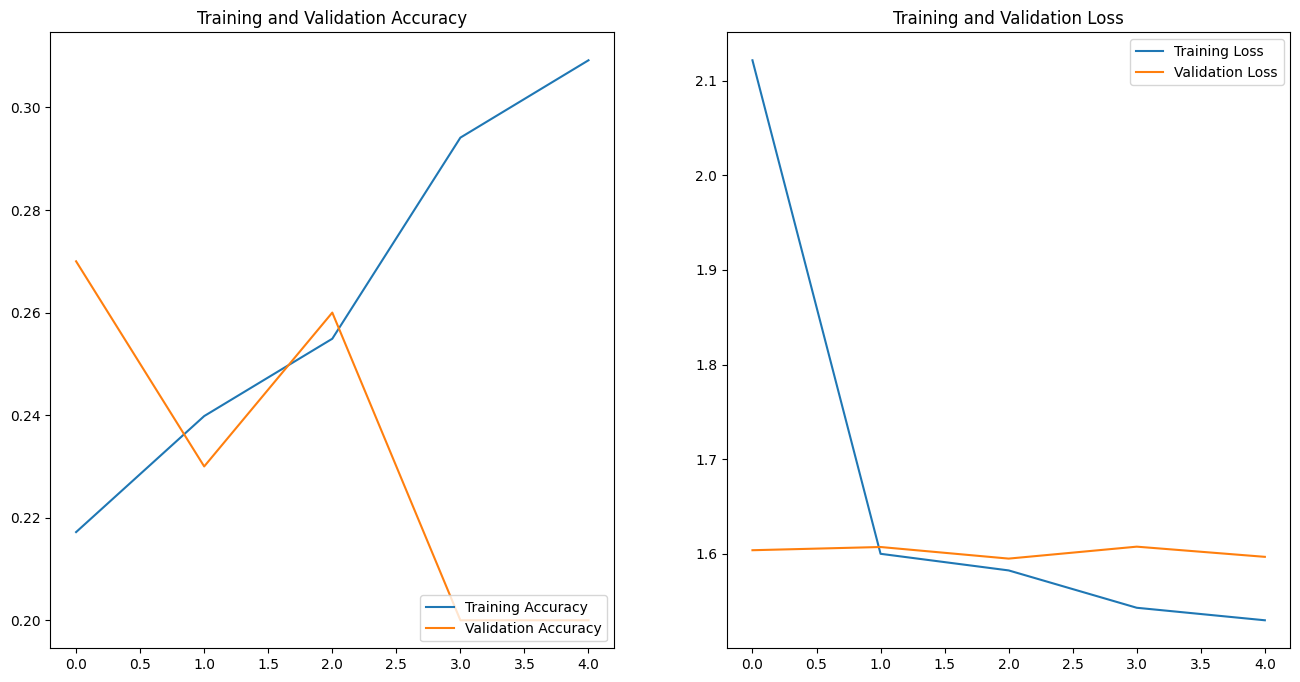

In [17]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observation**

the model is performing okay as both training and validation accuracy but need to increase the epochs of traing (limited resoureces) . We will try adding more layers to extract more features

## Experiment 2: Increasing Layer Set

In [18]:
# Define model
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Increased layer set
model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

In [19]:
# Using SGD optimizer with default LR=0.01
optimiser = keras.optimizers.SGD() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 18, 120, 120, 8)   656       
                                                                 
 batch_normalization_2 (Bat  (None, 18, 120, 120, 8)   32        
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 18, 120, 120, 8)   0         
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 9, 60, 60, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 9, 60, 60, 16)     3472      
                                                                 
 batch_normalization_3 (Bat  (None, 9, 60, 60, 16)    

In [20]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

<ipython-input-7-cb22f9bbc165>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/5
17/21 [=======================>......] - ETA: 16s - loss: 1.8968 - categorical_accuracy: 0.2059

<ipython-input-7-cb22f9bbc165>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch_size * num_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 1.8482 - categorical_accuracy: 0.2142
Epoch 1: val_loss did not improve from 1.59483
21/21 [==============================] - 105s 5s/step - loss: 1.8482 - categorical_accuracy: 0.2142 - val_loss: 1.6122 - val_categorical_accuracy: 0.1500 - lr: 0.0100
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 1.6323 - categorical_accuracy: 0.2353
Epoch 2: val_loss improved from 1.59483 to 1.59095, saving model to model_init_cnn_2024-04-0114_43_59.024271/model-00002-1.63226-0.23529.h5
21/21 [==============================] - 97s 5s/step - loss: 1.6323 - categorical_accuracy: 0.2353 - val_loss: 1.5909 - val_categorical_accuracy: 0.3400 - lr: 0.0100
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 1.6089 - categorical_accuracy: 0.1780
Epoch 3: val_loss did not improve from 1.59095
21/21 [==============================] - 99s 5s/step - loss: 1.6089 - categorical_accuracy: 0.1780 - val_loss: 1.6018 - val_cate

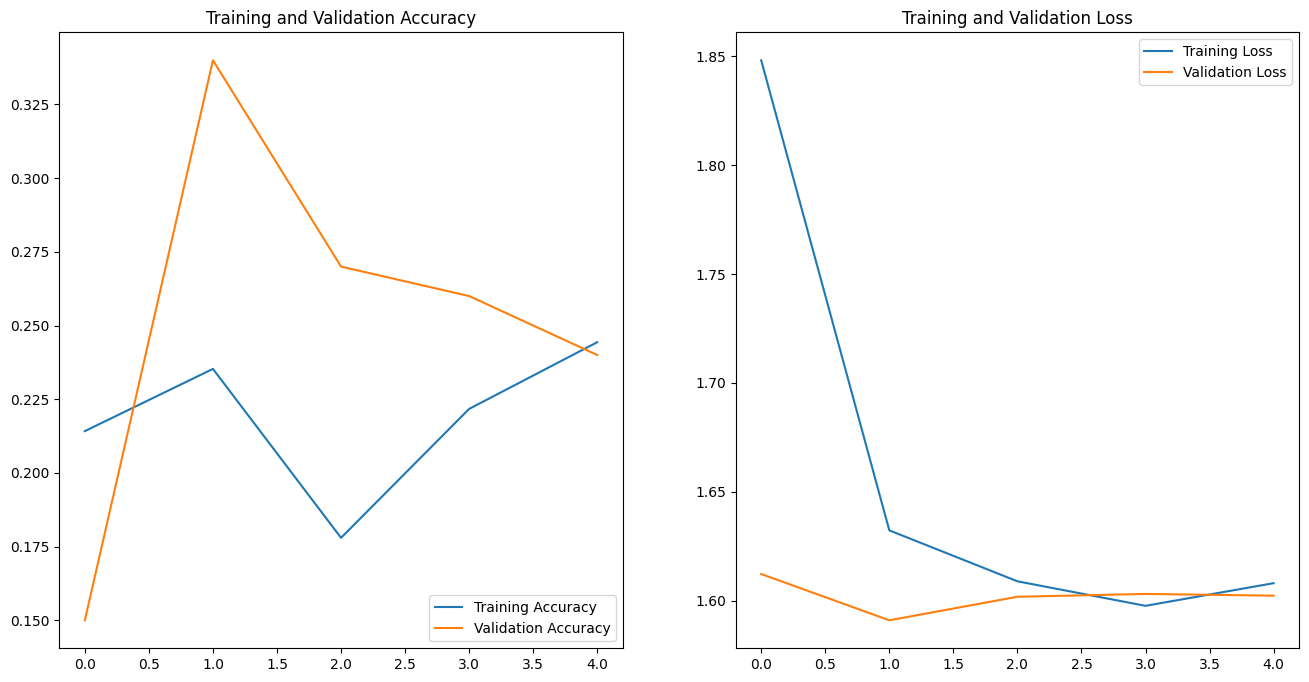

In [21]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

After adding more layers, the number of parameters dropped sharply. Hence the model is now underfitting. Both the training and validation accuracy are now under 0.55.
So we shall add more Kernels in dense layer of this model and see the output.

## Experiment 3: Increasing Dense Layer Kernels

In [22]:
# Define model
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

In [23]:
optimiser = keras.optimizers.SGD() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 18, 120, 120, 8)   656       
                                                                 
 batch_normalization_5 (Bat  (None, 18, 120, 120, 8)   32        
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 18, 120, 120, 8)   0         
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 9, 60, 60, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_8 (Conv3D)           (None, 9, 60, 60, 16)     3472      
                                                                 
 batch_normalization_6 (Bat  (None, 9, 60, 60, 16)    

In [24]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

<ipython-input-7-cb22f9bbc165>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/5
15/21 [====================>.........] - ETA: 23s - loss: 2.1229 - categorical_accuracy: 0.1979

<ipython-input-7-cb22f9bbc165>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch_size * num_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 2.0053 - categorical_accuracy: 0.2112
Epoch 1: val_loss did not improve from 1.59095
21/21 [==============================] - 105s 5s/step - loss: 2.0053 - categorical_accuracy: 0.2112 - val_loss: 1.6030 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 1.6300 - categorical_accuracy: 0.2398
Epoch 2: val_loss improved from 1.59095 to 1.58870, saving model to model_init_cnn_2024-04-0114_43_59.024271/model-00002-1.63004-0.23982.h5
21/21 [==============================] - 97s 5s/step - loss: 1.6300 - categorical_accuracy: 0.2398 - val_loss: 1.5887 - val_categorical_accuracy: 0.3300 - lr: 0.0100
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 1.5882 - categorical_accuracy: 0.2836
Epoch 3: val_loss improved from 1.58870 to 1.58105, saving model to model_init_cnn_2024-04-0114_43_59.024271/model-00003-1.58816-0.28356.h5
21/21 [============================

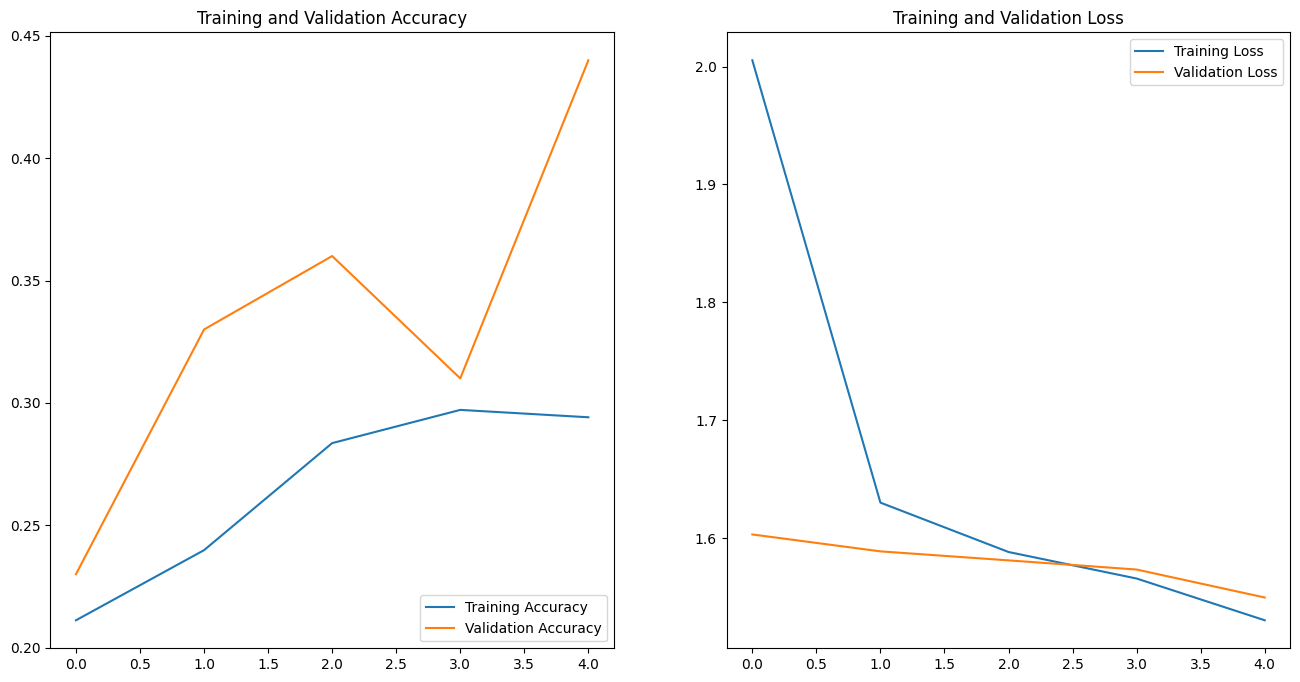

In [25]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

This model is performing very well as both validation and training accuracies are increasing steadily and the losses are also decreasing steadily. Also unlike Experiment 1, the number of parameters are much lower as well.

It looks like it is not able to converge in 30 epochs so we shall try increasing speed with increasing batch size.

## Experiment 4: Increasing batch size

In [26]:
batch_size=64

In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [28]:

optimiser = keras.optimizers.SGD() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 18, 120, 120, 8)   656       
                                                                 
 batch_normalization_5 (Bat  (None, 18, 120, 120, 8)   32        
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 18, 120, 120, 8)   0         
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 9, 60, 60, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_8 (Conv3D)           (None, 9, 60, 60, 16)     3472      
                                                                 
 batch_normalization_6 (Bat  (None, 9, 60, 60, 16)    

In [29]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

<ipython-input-7-cb22f9bbc165>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/5
 9/11 [=======================>......] - ETA: 15s - loss: 1.4895 - categorical_accuracy: 0.3628

<ipython-input-7-cb22f9bbc165>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch_size * num_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


11/11 [==============================] - ETA: 0s - loss: 1.4819 - categorical_accuracy: 0.3650
Epoch 1: val_loss improved from 1.54956 to 1.51810, saving model to model_init_cnn_2024-04-0114_43_59.024271/model-00001-1.48193-0.36501.h5
11/11 [==============================] - 109s 10s/step - loss: 1.4819 - categorical_accuracy: 0.3650 - val_loss: 1.5181 - val_categorical_accuracy: 0.4800 - lr: 0.0100
Epoch 2/5
11/11 [==============================] - ETA: 0s - loss: 1.4234 - categorical_accuracy: 0.4103
Epoch 2: val_loss improved from 1.51810 to 1.50895, saving model to model_init_cnn_2024-04-0114_43_59.024271/model-00002-1.42343-0.41026.h5
11/11 [==============================] - 101s 10s/step - loss: 1.4234 - categorical_accuracy: 0.4103 - val_loss: 1.5090 - val_categorical_accuracy: 0.5300 - lr: 0.0100
Epoch 3/5
11/11 [==============================] - ETA: 0s - loss: 1.4206 - categorical_accuracy: 0.3937
Epoch 3: val_loss improved from 1.50895 to 1.48923, saving model to model_init_

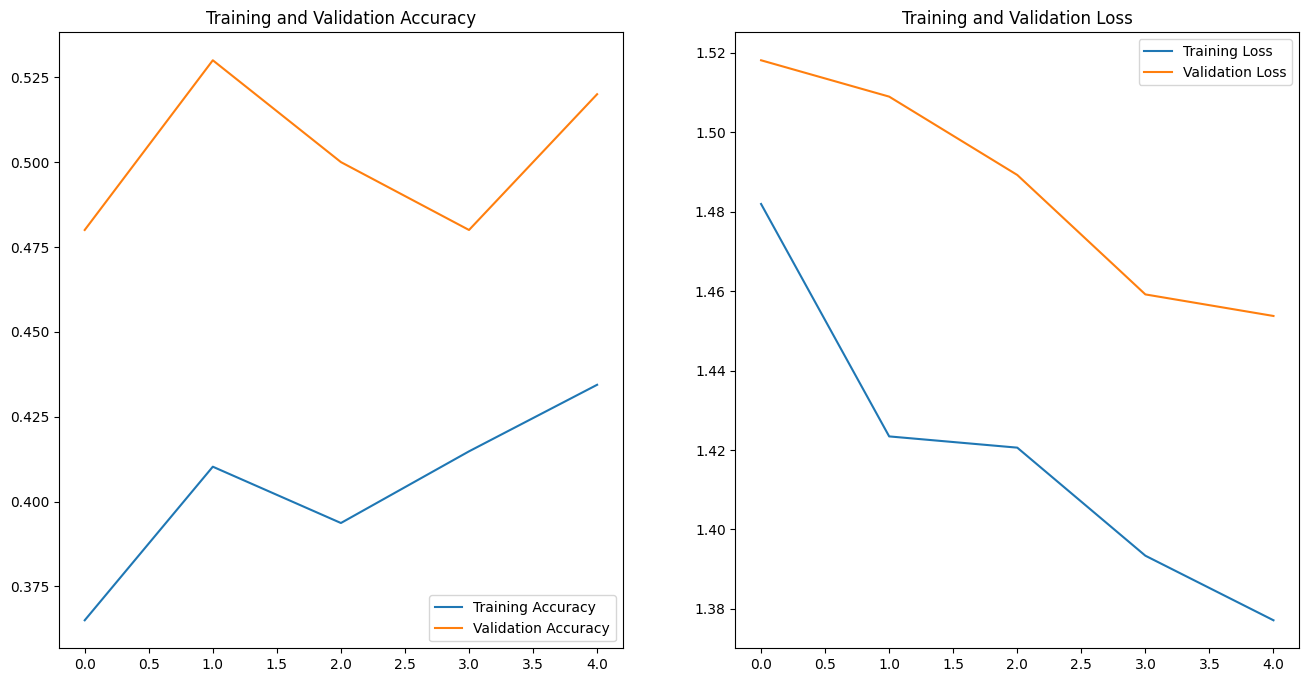

In [30]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

The training and validation accuracies both struggle in the beginning but start to increase very slowly later. We shall try increasing the learning rate as well and check if the model starts performing better



## Experiment 5: Increasing learning rate

In [31]:
num_epochs = 5

In [32]:
# Using SGD optimizer with LR=0.02 due to double batch size
optimiser = keras.optimizers.SGD(learning_rate=0.02)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 18, 120, 120, 8)   656       
                                                                 
 batch_normalization_5 (Bat  (None, 18, 120, 120, 8)   32        
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 18, 120, 120, 8)   0         
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 9, 60, 60, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_8 (Conv3D)           (None, 9, 60, 60, 16)     3472      
                                                                 
 batch_normalization_6 (Bat  (None, 9, 60, 60, 16)    

In [33]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

<ipython-input-7-cb22f9bbc165>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/5
 8/11 [====================>.........] - ETA: 25s - loss: 1.3290 - categorical_accuracy: 0.4414

<ipython-input-7-cb22f9bbc165>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch_size * num_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


11/11 [==============================] - ETA: 0s - loss: 1.3410 - categorical_accuracy: 0.4329
Epoch 1: val_loss improved from 1.45374 to 1.43340, saving model to model_init_cnn_2024-04-0114_43_59.024271/model-00001-1.34100-0.43288.h5
11/11 [==============================] - 111s 11s/step - loss: 1.3410 - categorical_accuracy: 0.4329 - val_loss: 1.4334 - val_categorical_accuracy: 0.5400 - lr: 0.0200
Epoch 2/5
11/11 [==============================] - ETA: 0s - loss: 1.3359 - categorical_accuracy: 0.4449
Epoch 2: val_loss did not improve from 1.43340
11/11 [==============================] - 119s 12s/step - loss: 1.3359 - categorical_accuracy: 0.4449 - val_loss: 1.4382 - val_categorical_accuracy: 0.3800 - lr: 0.0200
Epoch 3/5
11/11 [==============================] - ETA: 0s - loss: 1.2833 - categorical_accuracy: 0.4736
Epoch 3: val_loss improved from 1.43340 to 1.38891, saving model to model_init_cnn_2024-04-0114_43_59.024271/model-00003-1.28334-0.47360.h5
11/11 [=========================

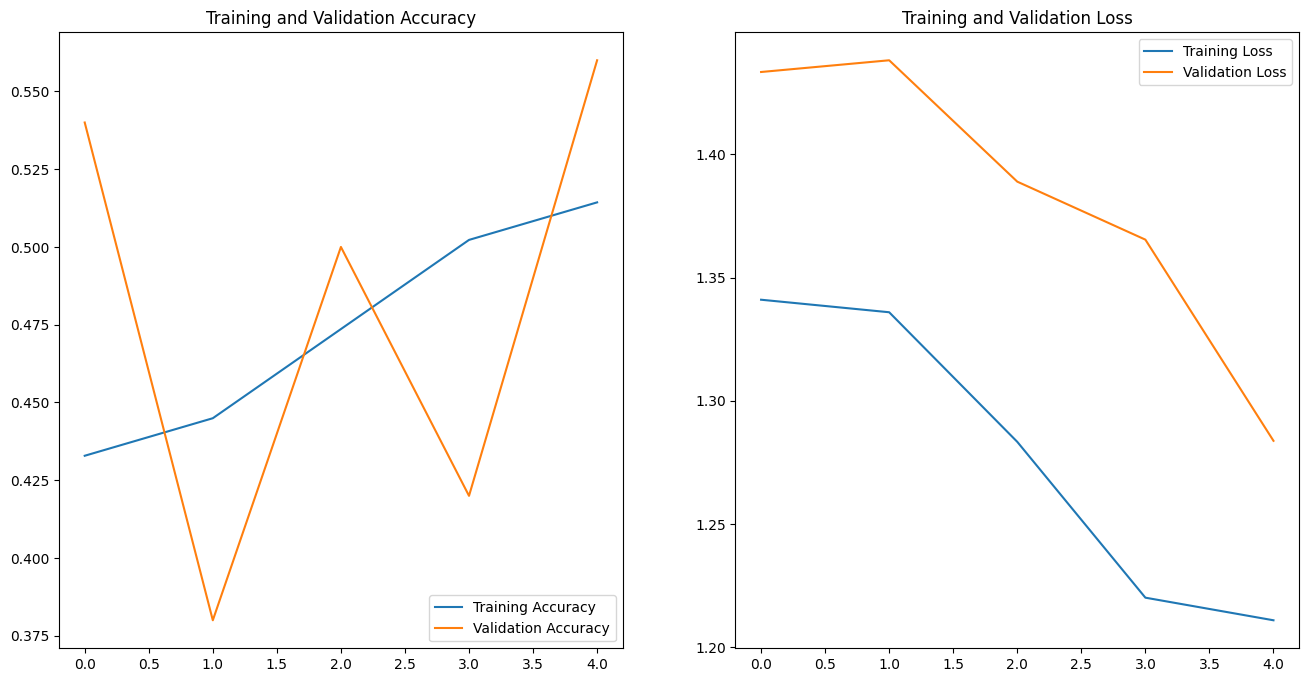

In [34]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

Increasing learning rate did not help acheieve the desired output. The model now overfits a lot. We shall try to increase the number of epochs of model and bring down the batch size to 32 and see if it is a better one

## Experiment 6: Increasing epochs to 8

In [35]:
num_epochs = 8

In [36]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
# Define model
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

In [38]:
# Defining SGD optimizer with default LR=0.01
optimiser = keras.optimizers.SGD()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 18, 120, 120, 8)   656       
                                                                 
 batch_normalization_8 (Bat  (None, 18, 120, 120, 8)   32        
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 18, 120, 120, 8)   0         
                                                                 
 max_pooling3d_11 (MaxPooli  (None, 9, 60, 60, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_12 (Conv3D)          (None, 9, 60, 60, 16)     3472      
                                                                 
 batch_normalization_9 (Bat  (None, 9, 60, 60, 16)    

In [39]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

<ipython-input-7-cb22f9bbc165>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/8
19/21 [==========================>...] - ETA: 7s - loss: 1.9570 - categorical_accuracy: 0.2418 

<ipython-input-7-cb22f9bbc165>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch_size * num_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 1.9460 - categorical_accuracy: 0.2293
Epoch 1: val_loss did not improve from 1.28375
21/21 [==============================] - 105s 5s/step - loss: 1.9460 - categorical_accuracy: 0.2293 - val_loss: 1.5908 - val_categorical_accuracy: 0.2900 - lr: 0.0100
Epoch 2/8
21/21 [==============================] - ETA: 0s - loss: 1.6515 - categorical_accuracy: 0.2549
Epoch 2: val_loss did not improve from 1.28375
21/21 [==============================] - 100s 5s/step - loss: 1.6515 - categorical_accuracy: 0.2549 - val_loss: 1.5860 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 3/8
21/21 [==============================] - ETA: 0s - loss: 1.5963 - categorical_accuracy: 0.2700
Epoch 3: val_loss did not improve from 1.28375
21/21 [==============================] - 99s 5s/step - loss: 1.5963 - categorical_accuracy: 0.2700 - val_loss: 1.5669 - val_categorical_accuracy: 0.3800 - lr: 0.0100
Epoch 4/8
21/21 [==============================] - ETA

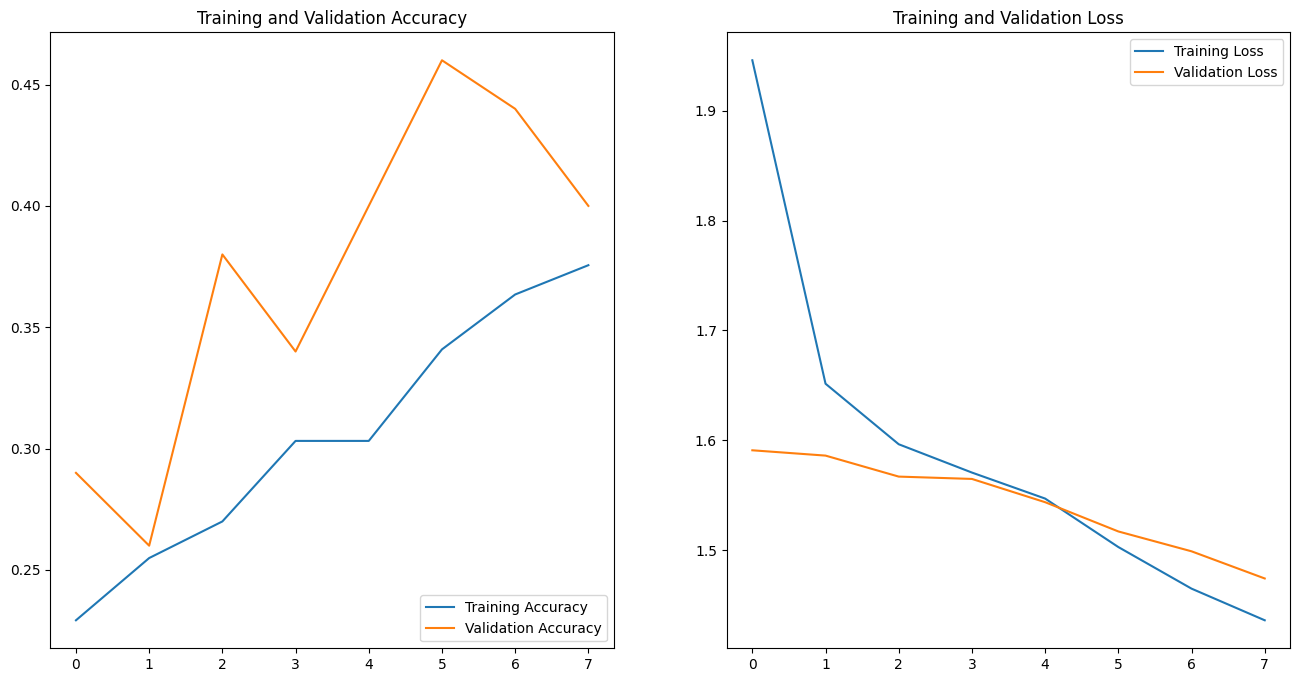

In [40]:
# Produce a graph for Accuracy and losses
plot_curves(history)

# CNN+RNN

We can also use another architecture of using CNN to extract features and RNN to process the extracted features in a time distributed fashion. This way we can acheieve a video processing NN. For this task, we can use pre-trained models and use the power of transfer learning. We shall choose MobileNetV2 CNN model since it is lightweight in nature which would suit the task in hand for application.

Since MobileNetV2 requires input to be processed in a specific format and shape we shall use preprocess_input() from keras mobilenet_v2 package and resize image to 128x128.

In [41]:
frame_width =128
frame_height=128

In [42]:
# using transfer learning so passing True
train_generator = generator(train_path, train_doc, batch_size, True)
val_generator = generator(val_path, val_doc, batch_size, True)

In [43]:
model_name = 'model_init_gru' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

In [44]:
# Adding checkpoint Callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = num_epochs)
# Adding ReduceLR callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

## Experiment 7: CNN+RNN with MobileNetV2 Transfer Learning + GRU layers

In [45]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(24, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
# Disable trainability of layers in MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(len(img_idx), 128, 128, 3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))

model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))

9406464/9406464 [==============================] - 0s 0us/step


In [46]:
# Compiling model with SGD optimizer with default LR of 0.01
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.build()
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 18, 24)            2749528   
 ributed)                                                        
                                                                 
 gru (GRU)                   (None, 18, 32)            5568      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dense_13 (Dense)            (None, 100)               1700      
                                                                 
 dense_14 (Dense)            (None, 5)                 505       
                                                                 
Total params: 2759701 (10.53 MB)
Trainable params: 501717 (1.91 MB)
Non-trainable params: 2257984 (8.61 MB)
____________

In [47]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

<ipython-input-7-cb22f9bbc165>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/8
 7/21 [=========>....................] - ETA: 54s - loss: 1.6392 - categorical_accuracy: 0.1607
Epoch 1: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00001-1.63240-0.18750.h5
15/21 [====================>.........] - ETA: 25s - loss: 1.6081 - categorical_accuracy: 0.2479
Epoch 1: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00001-1.60649-0.25586.h5
19/21 [==========================>...] - ETA: 8s - loss: 1.6004 - categorical_accuracy: 0.2697 

<ipython-input-7-cb22f9bbc165>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch_size * num_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - 130s 6s/step - loss: 1.5995 - categorical_accuracy: 0.2715 - val_loss: 1.5854 - val_categorical_accuracy: 0.3200 - lr: 0.0100
Epoch 2/8
 2/21 [=>............................] - ETA: 1:14 - loss: 1.5421 - categorical_accuracy: 0.4375
Epoch 2: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00002-1.54019-0.43750.h5
10/21 [=============>................] - ETA: 49s - loss: 1.5255 - categorical_accuracy: 0.4500
Epoch 2: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00002-1.52293-0.46023.h5
18/21 [========================>.....] - ETA: 13s - loss: 1.5085 - categorical_accuracy: 0.5174
Epoch 2: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00002-1.50751-0.51480.h5
21/21 [==============================] - 109s 5s/step - loss: 1.5056 - categorical_accuracy: 0.5189 - val_loss: 1.5045 - val_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 3/8
 5/21 [======>.......................] - ETA: 1:09 - loss: 1.4476 

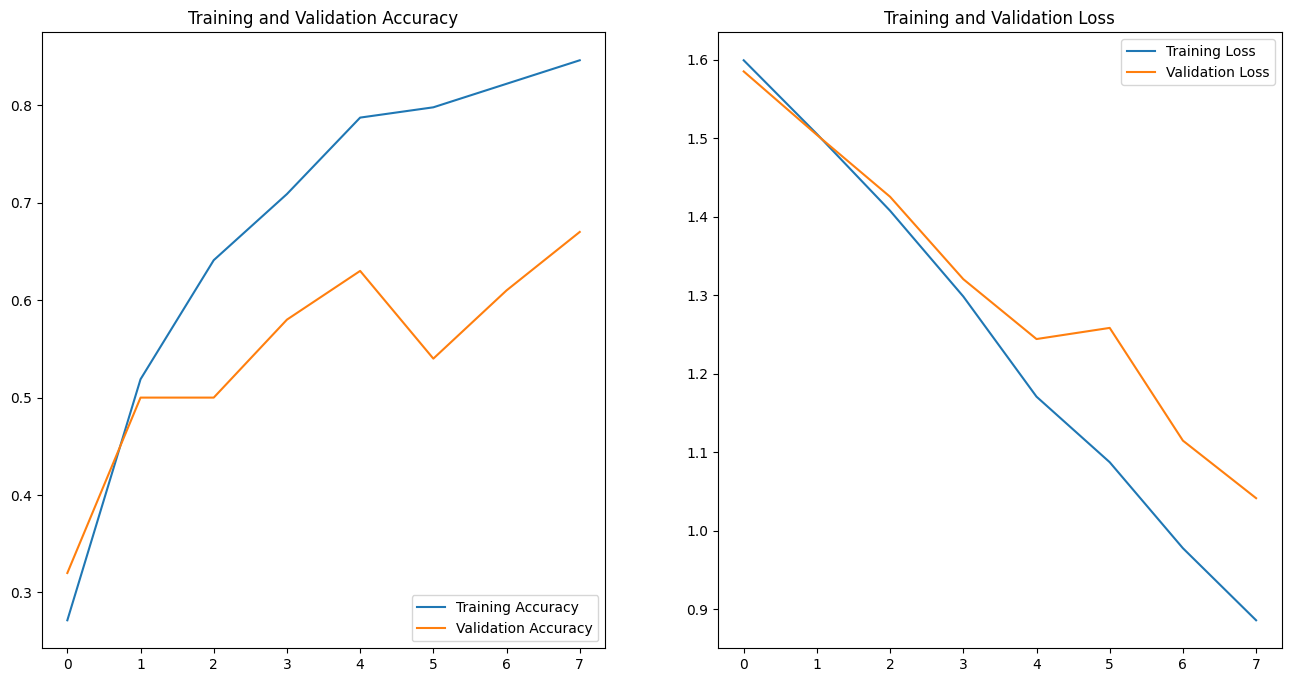

In [48]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

We can see that out model is overfitting since training accuracy is reaching  above 90% and validation accuracy is stagnant at 0.65. So we shall try adding dropout layer to mobilenetv2.

## Experiment 8: Decreasing the number of output neurons from MobileNet

In [49]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base_model.output
x = Flatten()(x)
# adding dropout for reducing neurons of MobileNet to combat oveerfitting
x = Dropout(0.5)(x)
# Adding dense layer of 24 kernels
features = Dense(24, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
# Disable trainability of layers in MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(len(img_idx), 128, 128, 3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))

model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [50]:
# Compiling model with SGD optimizer with default LR of 0.01
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.build()
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDi  (None, 18, 24)            2749528   
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 18, 32)            5568      
                                                                 
 gru_3 (GRU)                 (None, 16)                2400      
                                                                 
 dense_16 (Dense)            (None, 100)               1700      
                                                                 
 dense_17 (Dense)            (None, 5)                 505       
                                                                 
Total params: 2759701 (10.53 MB)
Trainable params: 501717 (1.91 MB)
Non-trainable params: 2257984 (8.61 MB)
____________

In [51]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

<ipython-input-7-cb22f9bbc165>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/8
 7/21 [=========>....................] - ETA: 1:00 - loss: 1.5996 - categorical_accuracy: 0.2277
Epoch 1: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00001-1.59591-0.23828.h5
15/21 [====================>.........] - ETA: 27s - loss: 1.5902 - categorical_accuracy: 0.2521
Epoch 1: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00001-1.58785-0.25781.h5
18/21 [========================>.....] - ETA: 13s - loss: 1.5845 - categorical_accuracy: 0.2535

<ipython-input-7-cb22f9bbc165>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch_size * num_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - 131s 6s/step - loss: 1.5808 - categorical_accuracy: 0.2624 - val_loss: 1.5481 - val_categorical_accuracy: 0.3000 - lr: 0.0100
Epoch 2/8
 2/21 [=>............................] - ETA: 4s - loss: 1.5176 - categorical_accuracy: 0.2812
Epoch 2: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00002-1.50301-0.34375.h5
10/21 [=============>................] - ETA: 43s - loss: 1.4981 - categorical_accuracy: 0.3500
Epoch 2: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00002-1.49155-0.37216.h5
18/21 [========================>.....] - ETA: 12s - loss: 1.4838 - categorical_accuracy: 0.3785
Epoch 2: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00002-1.48303-0.37829.h5
21/21 [==============================] - 113s 6s/step - loss: 1.4772 - categorical_accuracy: 0.3922 - val_loss: 1.4498 - val_categorical_accuracy: 0.4600 - lr: 0.0100
Epoch 3/8
 5/21 [======>.......................] - ETA: 53s - loss: 1.3852 - c

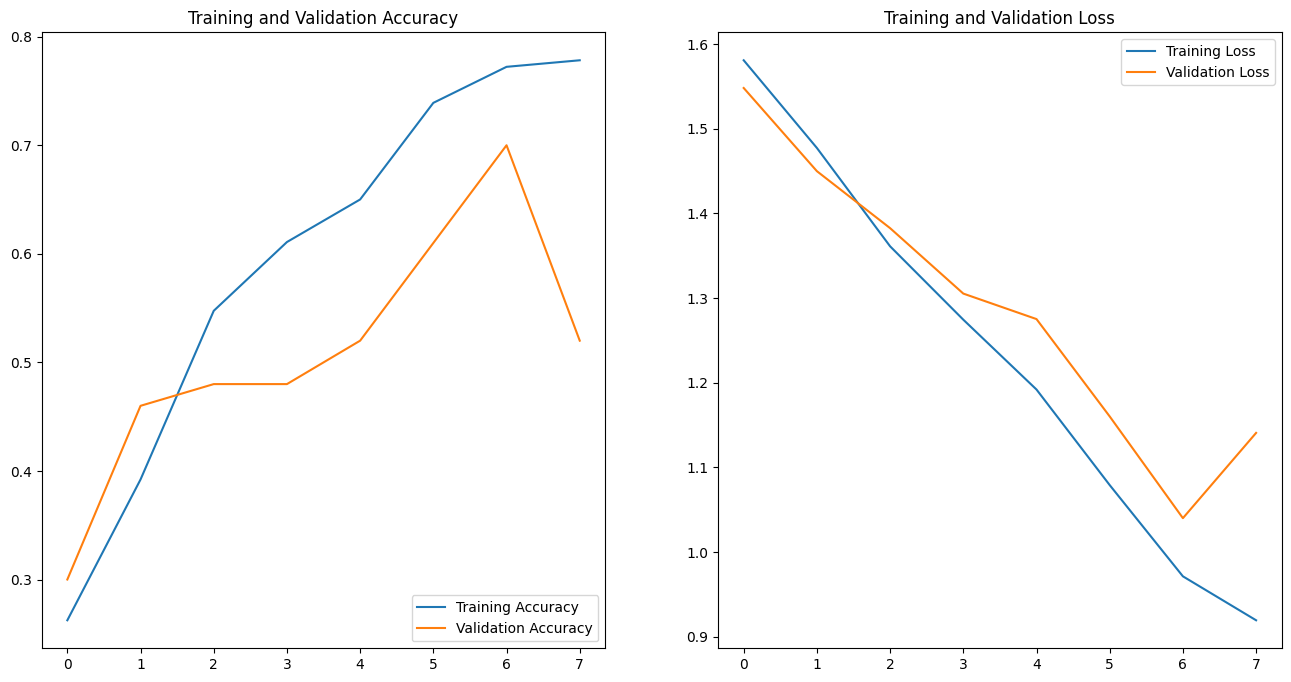

In [52]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

The model is still overfitting and there has been no improvement. We will now try combining multiple changes with some increase in parameters and some decrease. Also we shall tweak optimser as well

## Experiment 9: Decreasing batch size and learning rate, increasing GRU Kernels

In [53]:
batch_size = 16

In [54]:
# using transfer learning so passing True
train_generator = generator(train_path, train_doc, batch_size, True)
val_generator = generator(val_path, val_doc, batch_size, True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [55]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base_model.output
x = Flatten()(x)
# Adding dense layer of 64 kernels
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
# Disable trainability of layers in MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(len(img_idx), 128, 128, 3)))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))

model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [56]:
# Compiling model with SGD optimizer with  LR of 0.001, decay of 0.00006 and momentum=0.7
# Using legacy SGD optimizer
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 18, 64)            3568768   
 stributed)                                                      
                                                                 
 gru_4 (GRU)                 (None, 18, 64)            24960     
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dense_19 (Dense)            (None, 1000)              33000     
                                                                 
 dense_20 (Dense)            (None, 5)                 5005      
                                                                 
Total params: 3641141 (13.89 MB)
Trainable params: 1383157 (5.28 MB)
Non-trainable params: 2257984 (8.61 MB)
___________

In [57]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

<ipython-input-7-cb22f9bbc165>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/8
 7/42 [====>.........................] - ETA: 1:04 - loss: 1.6171 - categorical_accuracy: 0.1607
Epoch 1: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00001-1.61190-0.18750.h5
15/42 [=========>....................] - ETA: 1:00 - loss: 1.6076 - categorical_accuracy: 0.2042
Epoch 1: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00001-1.60645-0.21484.h5
23/42 [===============>..............] - ETA: 42s - loss: 1.6023 - categorical_accuracy: 0.2092
Epoch 1: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00001-1.60158-0.21094.h5
31/42 [=====================>........] - ETA: 25s - loss: 1.6009 - categorical_accuracy: 0.2077
Epoch 1: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00001-1.60048-0.21094.h5
39/42 [==========================>...] - ETA: 6s - loss: 1.5995 - categorical_accuracy: 0.2179
Epoch 1: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00001-1.59864-0.22031.h5
41/42 [=================

<ipython-input-7-cb22f9bbc165>:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch_size * num_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


42/42 [==============================] - 133s 3s/step - loss: 1.5994 - categorical_accuracy: 0.2157 - val_loss: 1.5887 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/8
 5/42 [==>...........................] - ETA: 56s - loss: 1.5633 - categorical_accuracy: 0.4000
Epoch 2: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00002-1.56038-0.40625.h5
13/42 [========>.....................] - ETA: 1:02 - loss: 1.5641 - categorical_accuracy: 0.3606
Epoch 2: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00002-1.56518-0.35714.h5
21/42 [==============>...............] - ETA: 46s - loss: 1.5664 - categorical_accuracy: 0.3512
Epoch 2: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00002-1.56699-0.34659.h5
29/42 [===================>..........] - ETA: 28s - loss: 1.5618 - categorical_accuracy: 0.3642
Epoch 2: saving model to model_init_gru_2024-04-0114_43_59.024271/model-00002-1.56181-0.36458.h5
37/42 [=========================>....] - ETA: 11s 

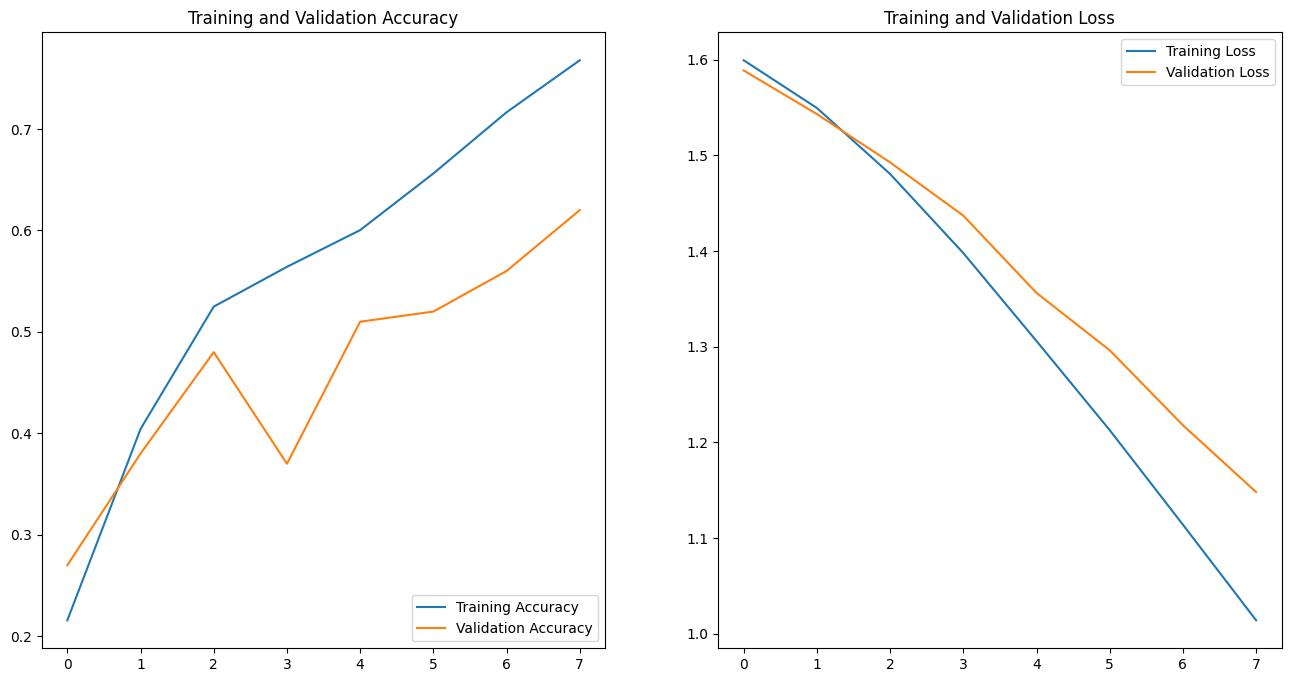

In [58]:
# Produce a graph for Accuracy and losses
plot_curves(history)

**Observations**

The model has a high tendency of overfitting. Adding dropouts and the learning rate reduction didnt help much. There is no improvement.

# Summary

The Experiment number 1 with CNN3D yield the best result in terms of training and validation accuracies.
Although there is further room for improvement which can be explored.